# 1. Library

In [1]:
#importing Useful DataStructures
import pandas as pd
import numpy as np
from scipy.stats import uniform

#importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

#importing Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

# Import XGBClassifier từ thư viện XGBoost
from xgboost import XGBClassifier

# Import LGBMClassifier từ thư viện LightGBM
from lightgbm import LGBMClassifier

# Import XGBRegressor từ thư viện XGBoost
from xgboost import XGBRegressor

# Import LGBMRegressor từ thư viện LightGBM
from lightgbm import LGBMRegressor


# 2. Function

In [ ]:
def reduce_mem_usage(data, verbose = True):
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)
    
    return data

In [3]:
def relational_tables_prepare(file_directory = '', verbose = True):
    '''
    Function to pickle the relational tables which would need to be merged during production with the 
    test datapoint
    
    Inputs:
        file_directory: str, default = ''
            The directory in which files are saved
        verbose: bool, default = True
            Whether to keep verbosity or not
    
    Returns:
        None
    '''
    
    if verbose:
        print("Loading the tables into memory...")
        start = datetime.now()
        
    #loading all the tables in memory, for dimensionality reduction
    with open(file_directory + 'bureau_merged_preprocessed.pkl', 'rb') as f:
        bureau_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'previous_application_preprocessed.pkl', 'rb') as f:
        previous_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'installments_payments_preprocessed.pkl', 'rb') as f:
        installments_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'POS_CASH_balance_preprocessed.pkl', 'rb') as f:
        pos_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'credit_card_balance_preprocessed.pkl', 'rb') as f:
        cc_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'application_train_preprocessed.pkl', 'rb') as f:
        application_train = reduce_mem_usage(pickle.load(f), verbose = False) 
    with open(file_directory + 'application_test_preprocessed.pkl', 'rb') as f:
        application_test = reduce_mem_usage(pickle.load(f), verbose = False)
    with open('Final_XGBOOST_Selected_features.pkl', 'rb') as f:
        final_cols = pickle.load(f)
        
    if verbose:
        print("Done.")
        print(f"Time Elapsed = {datetime.now() - start}")
        start2 = datetime.now()
        print("\nRemoving the non-useful features...")
    #removing non-useful columns from pre-processed previous_application table
    previous_app_columns_to_keep = set(previous_aggregated.columns).intersection(set(final_cols)).union(
                                    set([ele for ele in previous_aggregated.columns if 'AMT_ANNUITY' in ele] + [ele for ele in previous_aggregated.columns if 'AMT_GOODS' in ele]))
    previous_aggregated = previous_aggregated[previous_app_columns_to_keep]
    #removing non-useful columns from pre-processed credit_card_balance table
    credit_card_balance_columns_to_keep = set(cc_aggregated.columns).intersection(set(final_cols)).union(
                                    set([ele for ele in cc_aggregated.columns if 'AMT_RECEIVABLE_PRINCIPAL' in ele] + 
                                        [ele for ele in cc_aggregated.columns if 'AMT_RECIVABLE' in ele] + 
                                        [ele for ele in cc_aggregated.columns if 'TOTAL_RECEIVABLE' in ele] + ['SK_ID_CURR']))
    cc_aggregated = cc_aggregated[credit_card_balance_columns_to_keep]
    #removing non-useful columns from pre-processed installments_payments table
    installments_payments_columns_to_keep = set(installments_aggregated.columns).intersection(set(final_cols)).union(
                                            set([ele for ele in installments_aggregated.columns if 'AMT_PAYMENT' in 
                                                 ele and 'RATIO' not in ele and 'DIFF' not in ele] + ['AMT_INSTALMENT_MEAN_MAX', 'AMT_INSTALMENT_SUM_MAX']))
    installments_aggregated = installments_aggregated[installments_payments_columns_to_keep]
    #removing non-useful columns from pre-processed bureau-aggregated table
    bureau_columns_to_keep =  set(bureau_aggregated.columns).intersection(set(final_cols)).union([ele for ele in bureau_aggregated.columns
                                        if 'DAYS_CREDIT' in ele and 'ENDDATE' not in ele and 'UPDATE' not in ele] + [ele for ele in bureau_aggregated.columns if
                                        'AMT_CREDIT' in ele and 'OVERDUE' in ele] + [ele for ele in bureau_aggregated.columns if 'AMT_ANNUITY' in ele and 'CREDIT'  not in ele])
    bureau_aggregated = bureau_aggregated[bureau_columns_to_keep]
    
    if verbose:
        print("Done.")
        print(f"Time Elapsed = {datetime.now() - start2}")
        print("\nMerging all the tables, and saving to pickle file 'relational_table.pkl'...")

    #merging all the tables
    relational_table = cc_aggregated.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = reduce_mem_usage(relational_table, verbose = False)

    with open(file_directory + 'relational_table.pkl', 'wb') as f:
        pickle.dump(relational_table, f)
    
    if verbose:
        print("Done.")
        print(f"Total Time taken = {datetime.now() - start}")

In [ ]:
class modelling:
    '''
    Class for Doing Hyperparameter tuning to find best set of hyperparameters, building models on best hyperparams and
    displaying results on best hyperparameters.
    
    It has 4 methods:
        1. init method
        2. random_search_cv method
        3. train_on_best_params method
        4. proba_to_class method
        5. tune_threshold method
        6. results_on_best_params method
        7. feat_importances_show method
    '''
    def __init__(self, base_model, x_train, y_train, x_test, calibration = False, calibration_method = 'isotonic',
                 calibration_cv = 4, k_folds = 4, random_state = 982):
        '''
        Function to initialize the class members.
        
        Inputs: 
            self
            base_model: estimator/classifier
                The base model to be used for the modelling purpose
            x_train: numpy array
                Training standardized data
            y_train: numpy array
                Training class labels
            x_test: numpy array
                Test standardized data
            calibration: bool, default = False
                Whether to calibrate the model for generating class probabilities
            calibration_method: str, default = 'isotonic'
                The type of calibration to use, i.e. sigmoid or isotonic
            calibration_cv: int, default = 4
                Number of cross-validation folds for calibrating the probabilities
            k_folds: int, default = 4
                Number of cross-validation folds for training and tuning the model
            random_state: int, default = 982
                Random state for StratifiedKFold for reproducibility
                
        Returns: 
            None            
        '''
        self.base_model = base_model
        self.num_folds = k_folds
        self.kfolds = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = random_state)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.calibration = calibration
        if self.calibration:
            self.calibration_method = calibration_method
            self.calibration_cv = calibration_cv

    def random_search_cv(self, hyperparams_dict, n_iter = 30, verbose = True, n_jobs = 1, random_state = 843):
        '''
        Function to do RandomizedSearchCV on training data.
        
        Inputs:
            self
            hyperparams_dict: dict
                Dictionary of hyperparameters to tune
            n_iter: int, default = 30
                Number of iterations to perform for random search
            verbose: bool, default = True
                Whether to keep verbosity or not
            n_jobs: int, default = 1
                Number of cores to use for Random Search
            random_state: int, default = 843
                Random state for reproducibility of RandomizedSearchCV
                
        Returns:
            None
        '''
        
        if verbose:
            start = datetime.now()
            print(f"Doing Randomized Search CV on Classifier with {n_iter} random initializations...")
        rscv = RandomizedSearchCV(self.base_model, hyperparams_dict, n_iter = n_iter, scoring = 'roc_auc', 
                                  cv = self.kfolds, return_train_score = True, verbose = 2,
                                  n_jobs = n_jobs, random_state = random_state)
        rscv.fit(self.x_train, self.y_train)
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        
        #getting the Search Results
        self.tuning_results = pd.DataFrame(rscv.cv_results_)
        #best model
        self.best_model = rscv.best_estimator_
        
        gc.collect()
        
    def train_on_best_params(self, verbose = True):
        '''
        Function to train the model on best hyperparameters obtained from previous method.
        Generates Cross-Validation predictions as Out-of-fold predictions
        
        Inputs:
            self
            verbose: bool, default = True
                Whether to keep verbosity or not
        
        Returns:
            None
        '''
        
        if verbose:
            print("Fitting Classifier on best parameters\n")
            print(f"{self.num_folds}-Fold Cross Validation")
            start = datetime.now()
            
        self.cv_preds_probas = np.zeros(self.x_train.shape[0])
        #we will select a best threshold for each fold of cross-validation and average over the
        #folds to find the optimal threshold
        self.best_threshold_train = 0
        for fold_number, (train_indices, val_indices) in enumerate(self.kfolds.split(self.x_train, self.y_train), 1):
            if verbose:
                print(f"\tFitting Fold {fold_number}")
                
            self.best_model.fit(self.x_train[train_indices], self.y_train[train_indices])
            if not self.calibration:
                self.train_preds_probas = self.best_model.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.best_model.predict_proba(self.x_train[val_indices])[:,1]
            else:
                #fitting the calibration Classifier over the base model for calibrated probabilities
                self.calibrated_classifier = CalibratedClassifierCV(self.best_model, method = self.calibration_method, cv = self.calibration_cv)
                self.calibrated_classifier.fit(self.x_train[train_indices], self.y_train[train_indices])
                
                self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.calibrated_classifier.predict_proba(self.x_train[val_indices])[:,1]
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_probas) / self.num_folds
        
        #converting the class probabilities to class labels
        self.cv_preds_class = self.proba_to_class(self.cv_preds_probas, self.best_threshold_train)
        
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
            
        gc.collect()
    
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''
        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''
        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
        
    def results_on_best_params(self, model_name):
        '''
        Function to train the whole data on best parameters and display the results.
        
        Inputs:
            self
            model_name: str
                model name to get feature importances.
        
        Returns:
            None
        '''
        #we have to fit the whole model for optimal test predictions
        self.best_model.fit(self.x_train, self.y_train)
        if not self.calibration:
            self.train_preds_probas = self.best_model.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.best_model.predict_proba(self.x_test)[:,1]
        else:
            #fitting calibration model over whole training data for test predictions
            self.calibrated_classifier.fit(self.x_train, self.y_train)
            self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.calibrated_classifier.predict_proba(self.x_test)[:,1]
        
        #getting class labels from probabilities
        self.train_preds_class = self.proba_to_class(self.train_preds_probas, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_probas, self.best_threshold_train)
        
        #feature importances
        if model_name == 'linear':
            self.feat_imp = self.best_model.coef_[0]
        else:
            self.feat_imp = self.best_model.feature_importances_
                
        print("=" * 100)
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        print("Train Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        print('=' * 100)
        print("Confusion Matrix of CV data:")
        conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
        conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
        plt.figure(figsize = (7,6))
        plt.title('Confusion Matrix Heatmap')
        sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
        plt.show()
        
        print('=' * 100)
        print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
        plt.figure(figsize = (20,6))
        plt.subplot(1,3,1)
        plt.title('Class Distribution of Original Dataset')
        sns.countplot(self.y_train)
        plt.subplot(1,3,2)
        plt.title('Class Distribution of predicted Class Labels on CV')
        sns.countplot(self.cv_preds_class)
        plt.subplot(1,3,3)
        plt.title('Class Distribution of predicted Test Dataset')
        sns.countplot(self.test_preds_class)
        plt.show()
        print('=' * 100)
        
        gc.collect()
        
    def feat_importances_show(self, feature_names, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            feature_names: numpy array
                Names of features of training set
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        #getting the top features indices and their names
        top_feats_indices = np.argsort(self.feat_imp)[::-1][:num_features]
        feat_importance_top = self.feat_imp[top_feats_indices]
        column_names = feature_names[top_feats_indices]
        
        #plotting a horizontal bar plot of feature importances
        plt.figure(figsize = figsize) 
        sns.barplot(feat_importance_top, list(range(num_features)), orient = 'h')
        plt.yticks(list(range(50)), column_names)
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

# 3. PreModel

In [ ]:
import pickle

# Dataset in Kaggle 
data_path = '/kaggle/input/datafortestmodel'

# Preproccessing File 
train_file = f'{data_path}/train_data_final.pkl'
test_file = f'{data_path}/test_data_final.pkl'

# Reading Dataset 
with open(train_file, 'rb') as file:
    train = pickle.load(file)

with open(test_file, 'rb') as file:
    test = pickle.load(file)

# Dataset Checking
print(f"Train Data: {type(train)}, Test Data: {type(test)}")


Train Data: <class 'pandas.core.frame.DataFrame'>, Test Data: <class 'pandas.core.frame.DataFrame'>


In [6]:
train.drop('Unnamed: 0', axis = 1, inplace = True)
test.drop('Unnamed: 0', axis = 1, inplace = True)

In [7]:
#removing the SK_ID_CURR from training and test data
train_data = train.drop(['SK_ID_CURR'], axis = 1)
skid_test = test.pop('SK_ID_CURR')
#extracting the class labels for training data
target_train = train_data.pop('TARGET')

In [8]:
empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <=1:
        empty_columns.append(col)
    
print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
train_data = train_data.drop(empty_columns, axis = 1)
test_data = test.drop(empty_columns, axis = 1)

There are 23 columns with just 1 unique value
Removing these from dataset


In [9]:
class recursive_feature_selector:
    '''
    Class to recursively select top features.
    Contains 2 methods:
        1. init method
        2. main method
    '''
   
    def __init__(self, train_data, test_data, target_train, num_folds = 3, verbose = True, random_state = 5358):
        '''
        Function to initialize the class variables.
        
        Inputs:
            self
            train_data: DataFrame
                Training Data
            test_data: DataFrame
                Test Data
            target_train: Series
                Class Labels for training Data
            num_folds: int, default = 3
                Number of folds for K-Fold CV
            verbose: bool, default = True
                Whether to keep verbosity or not
            random_state: int, default = 5358
                The random state for the classifier for recursive feature selection
                
        Returns: 
            None
        '''
        
        self.train_data = train_data
        self.test_data = test_data
        self.target_train = target_train
        self.num_folds = num_folds
        self.verbose = verbose
        self.random_state = random_state
        
        # Clean column names
        self.train_data.columns = self.train_data.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)
        self.test_data.columns = self.test_data.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)

    def main(self):
        '''
        Function to select features recursively
        
        Inputs:
            self
        
        Returns:
            Training and testing data with reduced number of features
        '''
        
        if self.verbose:
            print("Starting Feature Selection...")
            start = datetime.now()
            
        # set of important features
        self.important_columns = set()
        score = 1
        i = 1
        
        while score > 0.72:
            if self.verbose:
                print(f"Iteration {i}:")
                
            # removing the features which have been selected from the modelling data
            selection_data = self.train_data.drop(list(self.important_columns), axis=1)
            # defining the CV strategy
            fold = StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=33)
            # reinitializing the score
            score = 0
            model_feature_importance = np.zeros_like(selection_data.columns)
            
            # doing K-Fold Cross validation
            for fold_num, (train_indices, val_indices) in enumerate(fold.split(selection_data, self.target_train), 1):
                if self.verbose:
                    print(f"\t\tFitting fold {fold_num}")
                
                # defining the train and validation data
                x_train = selection_data.iloc[train_indices]
                x_val = selection_data.iloc[val_indices]
                y_train = self.target_train.iloc[train_indices]
                y_val = self.target_train.iloc[val_indices]
                
                # instantiating the LightGBM Classifier
                lg = LGBMClassifier(n_jobs=-1, random_state=self.random_state)
                lg.fit(x_train, y_train)

                # appending the feature importance of each feature averaged over different folds
                model_feature_importance += lg.feature_importances_ / self.num_folds
                # average k-fold ROC-AUC Score
                score += roc_auc_score(y_val, lg.predict_proba(x_val)[:, 1]) / self.num_folds

            # getting the non-zero feature importance columns
            imp_cols_indices = np.where(np.abs(model_feature_importance) > 0)
            # names of non-zero feature importance columns
            cols_imp = self.train_data.columns[imp_cols_indices]
            
            if score > 0.7:
                self.important_columns.update(cols_imp)
                if self.verbose:
                    print(f"\tNo. of important columns kept = {len(self.important_columns)}")            
            if self.verbose:
                print(f"\tCross Validation score = {score}")
            i += 1
            
        self.important_columns = list(self.important_columns)
        
        if self.verbose:
            print("\nDone Selecting Features.")
            print(f"Total columns removed = {self.train_data.shape[1] - len(self.important_columns)}")
            print(f"\nInitial Shape of train_data = {self.train_data.shape}")
        self.train_data = self.train_data[self.important_columns]
        self.test_data = self.test_data[self.important_columns]
        if self.verbose:
            print(f"Final Shape of train_data = {self.train_data.shape}")
            print(f"\nTotal Time Taken = {datetime.now() - start}")
            
        # saving the final columns into a pickle file
        with open('final_cols.pkl', 'wb') as f:
            pickle.dump(self.important_columns, f)
        
        gc.collect()

        return self.train_data, self.test_data


# Instantiate the class recursive_feature_selector
feature_selector = recursive_feature_selector(train_data, test_data, target_train)
train_data, test_data = feature_selector.main()
important_columns = feature_selector.important_columns


Starting Feature Selection...
Iteration 1:
		Fitting fold 1
[LightGBM] [Info] Number of positive: 13251, number of negative: 150753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.916977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 275812
[LightGBM] [Info] Number of data points in the train set: 164004, number of used features: 1602
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080797 -> initscore=-2.431570
[LightGBM] [Info] Start training from score -2.431570
		Fitting fold 2
[LightGBM] [Info] Number of positive: 13251, number of negative: 150753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 11.252331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 275697
[LightGBM] [Info] Number of data points in the train set: 164004, number of used features: 1602
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080797

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_data)
x_test_std = scaler.transform(test_data)  
y_train = target_train

# CNumPy array to DataFrame 
x_train_std = pd.DataFrame(x_train_std, columns=train_data.columns)
x_test_std = pd.DataFrame(x_test_std, columns=test_data.columns)

# Fill NaN
for col in x_train_std.columns:
    if x_train_std[col].dtype in ['float64', 'int64']: 
        mean_value = x_train_std[col].mean()
        x_train_std[col].fillna(mean_value, inplace=True)
        x_test_std[col].fillna(mean_value, inplace=True)
    else: 
        mode_value = x_train_std[col].mode()[0] 
        x_train_std[col].fillna(mode_value, inplace=True)
        x_test_std[col].fillna(mode_value, inplace=True)

x_train_std = x_train_std.to_numpy()
x_test_std = x_test_std.to_numpy()


# 4. Model

Doing Randomized Search CV on Classifier with 70 random initializations...
Fitting 4 folds for each of 50 candidates, totalling 200 fits
Done.
Time elapsed = 7:20:32.735279


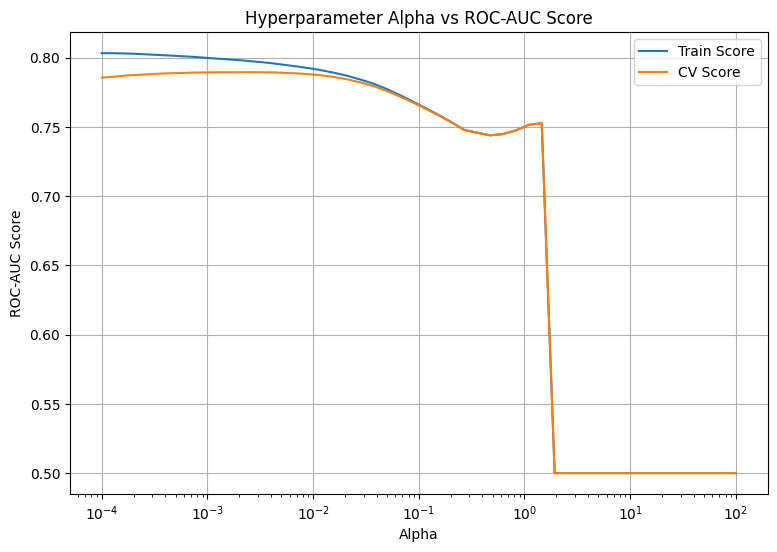

In [11]:

params = {
    'loss' : 'log_loss',
    'penalty' : 'elasticnet',
    'random_state' : 42,
    'class_weight' : 'balanced',
    'n_jobs' : -1,
    'learning_rate': 'adaptive',
    'l1_ratio': 0.16, 
    'eta0': 0.011616 
}
clf = SGDClassifier(**params)
hyperparams = {'alpha' : np.logspace(-4,2)}

sgd_lr_l2 = modelling(clf, x_train_std, y_train, x_test_std)

#lets do randomized search cv first
sgd_lr_l2.random_search_cv(hyperparams, n_iter = 70, n_jobs = 2)

#visualizing the cv results
cv_results = sgd_lr_l2.tuning_results
cv_results = cv_results.sort_values('param_alpha')

#plotting the train and cv scores
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Train Score')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'CV Score')
plt.title('Hyperparameter Alpha vs ROC-AUC Score')
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()


Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
[CV] END .......................................alpha=0.0001; total time= 8.1min
[CV] END .......................................alpha=0.0001; total time= 8.1min
[CV] END .......................alpha=0.00013257113655901095; total time= 8.0min
[CV] END .......................alpha=0.00013257113655901095; total time= 7.2min
[CV] END .......................alpha=0.00017575106248547912; total time= 7.6min
[CV] END .......................alpha=0.00017575106248547912; total time= 9.6min
[CV] END .......................alpha=0.00023299518105153718; total time= 7.4min
[CV] END .......................alpha=0.00023299518105153718; total time= 7.9min
[CV] END .......................alpha=0.00030888435964774815; total time= 6.5min
[CV] END .......................alpha=0.00030888435964774815; total time= 7.2min
[CV] END .......................alpha=0.00040949150623804275; total time= 6.8min
[CV] END .....................

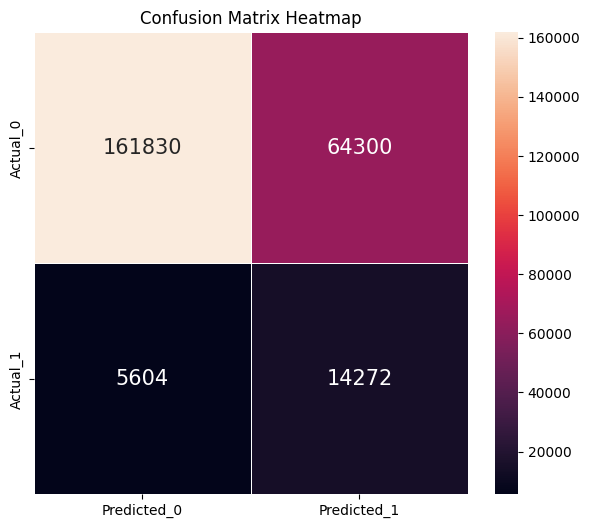

Distribution of Original Class Labels and Predicted CV and Test Class Labels


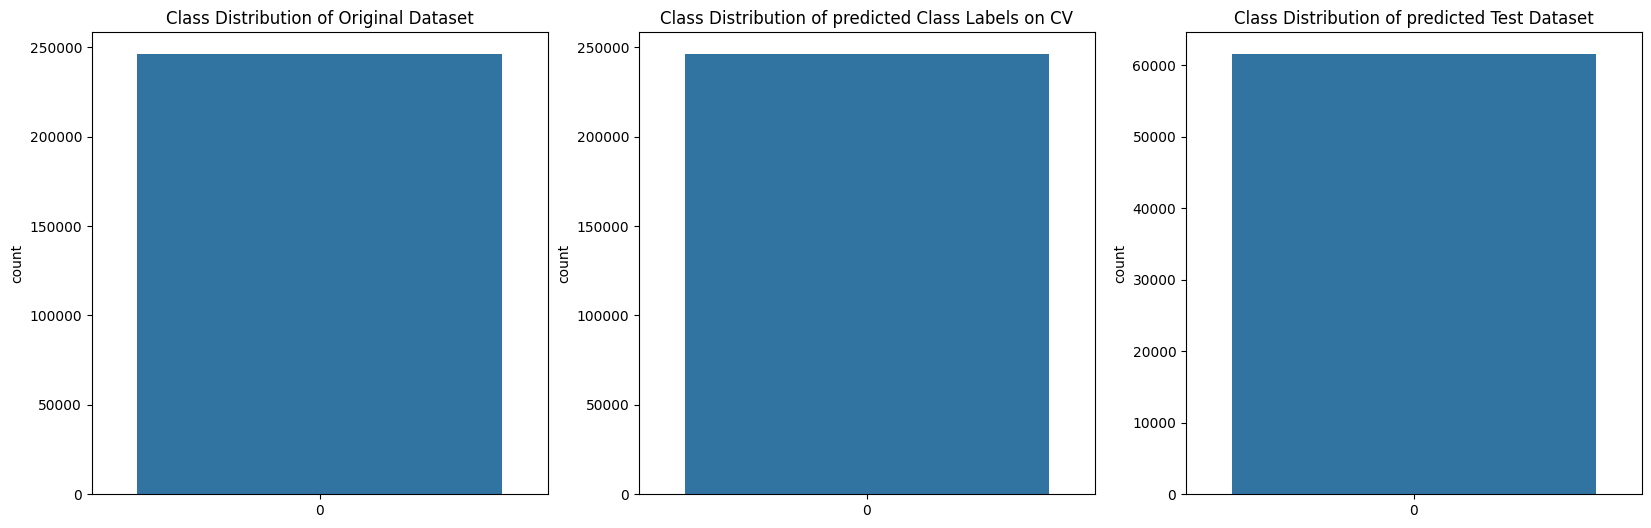

In [12]:
#training on best parameters
sgd_lr_l2.train_on_best_params()
#showing the results
sgd_lr_l2.results_on_best_params('linear')


In [13]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : sgd_lr_l2.test_preds_probas}).to_csv('submissionLRL2_mean_fillnul_07.csv',index = False)
print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk
